## Setup ##

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import skimage as sk
import cv2

from sklearn.model_selection import train_test_split
%matplotlib inline
from skimage.transform import resize


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [128]:
torch.cuda.is_available()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

(512, 512, 3)
(256, 256, 3)


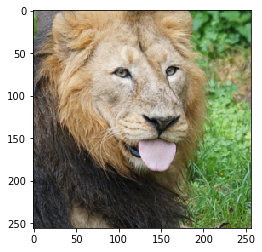

In [129]:
im = plt.imread("input/lion_orig.png")
im = sk.img_as_float(im)
print(im.shape)
im = resize(im, (im.shape[0]//2, im.shape[1]//2), anti_aliasing=True)
print(im.shape)
plt.imshow(im)

## Positional Encoding Implementation ##

In [130]:
def pos_enc(p, L): 
    if L <= 0:
        return p
    v_proj = (np.pi * p)
    out_enc = np.concatenate([np.sin(v_proj), np.cos(v_proj)], axis=-1)
    for l in np.arange(1, L):
        v_proj = (pow(2.0, l) * np.pi * p)
        out_enc = np.concatenate([out_enc, np.sin(v_proj), np.cos(v_proj)], axis=-1)
    return out_enc

## Apply Positional Encodings to Different Sections of the Image ##

In [131]:
def createCoordSets(im, percent=0.6):
    coords = np.linspace(0, 1, im.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    
    ymin = int((1.0-percent)/2*im.shape[0])
    ymax = int((percent + (1.0-percent)/2)*im.shape[0])
    
    xmin = int((1.0-percent)/2*im.shape[1])
    xmax = int((percent + (1.0-percent)/2)*im.shape[1])
    
    center = x_test[ymin:ymax,xmin:xmax, :].reshape(-1, x_test.shape[-1])

    b1 = x_test[:ymin, :].reshape(-1, x_test.shape[-1])
    b2 = x_test[ymin:ymax, :xmin].reshape(-1, x_test.shape[-1])
    b3 = x_test[ymin:ymax, xmax:].reshape(-1, x_test.shape[-1])
    b4 = x_test[ymax:, :].reshape(-1, x_test.shape[-1])
    border = np.vstack([b1, b2, b3, b4])
    
    #y_center = im[y:y+w,x:x+h, :]
    #y_border = im[]
    
    return center, border, im, im

def genTrain(im, L=8):
    X_center, X_border, y_center, y_border = createCoordSets(im)

    # Center
    X_c = torch.from_numpy(pos_enc(X_center, L))
    y_c = torch.from_numpy(y_center)
    X_c = X_c.to(device)
    y_c = y_c.to(device)

    # Border
    X_b = torch.from_numpy(pos_enc(X_border, L))
    y_b = torch.from_numpy(y_border)
    X_b = X_c.to(device)
    y_b = y_c.to(device)
    
    return X_c, y_c, X_b, y_b

## Model Specification ##

In [132]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(max(2, 4*L), 256), # add 6 layers
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [133]:
def trainModel(X_train, y_train, L=8, lr=1e-4, epochs=2000, visual=False, verbal=True, model_class=MLP):
    
    model = model_class()
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        model.train()
        X_train.to(device)
        outputs = model(X_train.float())
        loss = loss_fn(outputs, y_train.float())
        if verbal and epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()

        if visual and epoch % 100 == 0:
            plt.imshow(outputs.cpu().detach().numpy())
            plt.show()

        model.eval()
    return model, outputs.cpu().detach().numpy()

## Train Model for Center and Border ##

In [134]:
X_c, y_c, X_b, y_b = genTrain(im)

# Center
model_c, output_c = trainModel(X_c, y_c)

RuntimeError: The size of tensor a (23409) must match the size of tensor b (256) at non-singleton dimension 1

In [122]:
X_c.shape

torch.Size([23409, 32])